Intention of this notebook is to train the most relevant models (S_E, A13 and S_E_A13) on the T1626 dataset (also filtered), to be able to retrospectively validate them later on the prospective (T96) and retrospective (T251) Merck&Co+ datasets.

For this purpose the models are saved into a pickle file together with their hypermarameters. For this to work all sub-datasets (T1626, T251, T96) have to be aligned, meaning the features are called the same in all used files and are also in the same order.

For the current nomenclature refer to tha model names in brackets.

## Notebook Setup

In [0]:
#Imports:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pickle as pkl

In [0]:
#Connect to google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Set up file paths:
data_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1626/cnn_rep_sampler_T1626/"
base_data_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1626/paper_datasets_T1626/"
model_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Models/Validation_Models/"

y_target_loc = base_data_folder_loc + "y_label_xgboost_T1626.csv"
X_paper_loc =  base_data_folder_loc + "X_paper_xgboost_T1626.csv"
unambiguous_sequence_mut_filter_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1626/sequence_sampler_T1626/unambiguous_mut_filter_T1626.csv"

X_seq_all_01_loc =  data_folder_loc + "sequence_cnn_rep_all_default_01.csv"
X_seq_all_02_loc =  data_folder_loc + "sequence_cnn_rep_all_default_02.csv"
X_seq_all_03_loc =  data_folder_loc + "sequence_cnn_rep_all_default_03.csv"

parameter_table_paper_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Models/Paper_Features_Own_Baseline/results_paper_own_baseline_xgboost_T1626.pkl"
parameter_table_seq_rep_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Models/CNN_Features/results_default_cnn_all_01_02_03_xgboost_T1626.csv"
parameter_table_combined_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Models/CNN_Features_Paper_Features_Combined/results_paper_cnn_all_01_02_03_xgboost_T1626.csv"

print("Folders: ")
print("\t",os.path.isdir(data_folder_loc))
print("\t",os.path.isdir(base_data_folder_loc))
print("\t",os.path.isdir(model_folder_loc))
print("Files: ")
print("\t",os.path.isfile(y_target_loc))
print("\t",os.path.isfile(X_seq_all_01_loc))
print("\t",os.path.isfile(X_seq_all_02_loc))
print("\t",os.path.isfile(X_seq_all_03_loc))
print("\t",os.path.isfile(X_paper_loc))
print("\t",os.path.isfile(unambiguous_sequence_mut_filter_loc))
print("\t",os.path.isfile(parameter_table_paper_loc))
print("\t",os.path.isfile(parameter_table_seq_rep_loc))
print("\t",os.path.isfile(parameter_table_combined_loc))

Folders: 
	 True
	 True
	 True
Files: 
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True


In [0]:
#XGBoost
!pip install xgboost==0.82 #working GPU support
import xgboost as xgb

In [0]:
#BayersianOptimization
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

## Prepare Data

In [0]:
#Just load data
y_label = pd.read_csv(y_target_loc)["dtm"].values 
unambiguous_mut_filter = pd.read_csv(unambiguous_sequence_mut_filter_loc)["Unambiguous"].values


X_seq_all_01 = pd.read_csv(X_seq_all_01_loc, index_col=0)
X_seq_all_01.columns = list(map(lambda x: "layer_01_"+x, X_seq_all_01.columns))
X_seq_all_02 = pd.read_csv(X_seq_all_02_loc, index_col=0)
X_seq_all_02.columns = list(map(lambda x: "layer_02_"+x, X_seq_all_02.columns))
X_seq_all_03 = pd.read_csv(X_seq_all_03_loc, index_col=0)
X_seq_all_03.columns = list(map(lambda x: "layer_03_"+x, X_seq_all_03.columns))

X_paper = pd.read_csv(X_paper_loc) 

parameter_table_paper = pd.read_pickle(parameter_table_paper_loc)
parameter_table_seq_rep = pd.read_csv(parameter_table_seq_rep_loc, index_col="Unnamed: 0")
parameter_table_combined = pd.read_csv(parameter_table_combined_loc, index_col="Unnamed: 0")

In [0]:
X_seq_all_01_02_03 = pd.concat([X_seq_all_01, X_seq_all_02, X_seq_all_03], axis=1)
X_seq_all_01_02_03 = X_seq_all_01_02_03.reset_index(drop=True)

In [0]:
print(X_paper.shape)
print(X_seq_all_01_02_03.shape)

(1626, 158)
(1626, 5376)


In [0]:
X_paper_all_01_02_03 = pd.concat([X_seq_all_01_02_03, X_paper], axis=1)

In [0]:
print(X_paper_all_01_02_03.shape)
X_paper_all_01_02_03.head()

(1626, 5534)


,layer_01_wt_rep_0,layer_01_wt_rep_1,layer_01_wt_rep_2,layer_01_wt_rep_3,layer_01_wt_rep_4,layer_01_wt_rep_5,layer_01_wt_rep_6,layer_01_wt_rep_7,layer_01_wt_rep_8,layer_01_wt_rep_9,layer_01_wt_rep_10,layer_01_wt_rep_11,layer_01_wt_rep_12,layer_01_wt_rep_13,layer_01_wt_rep_14,layer_01_wt_rep_15,layer_01_wt_rep_16,layer_01_wt_rep_17,layer_01_wt_rep_18,layer_01_wt_rep_19,layer_01_wt_rep_20,layer_01_wt_rep_21,layer_01_wt_rep_22,layer_01_wt_rep_23,layer_01_wt_rep_24,layer_01_wt_rep_25,layer_01_wt_rep_26,layer_01_wt_rep_27,layer_01_wt_rep_28,layer_01_wt_rep_29,layer_01_wt_rep_30,layer_01_wt_rep_31,layer_01_wt_rep_32,layer_01_wt_rep_33,layer_01_wt_rep_34,layer_01_wt_rep_35,layer_01_wt_rep_36,layer_01_wt_rep_37,layer_01_wt_rep_38,layer_01_wt_rep_39,...,mono_fa_intra_rep,mono_fa_pair,mono_fa_rep,mono_fa_sol,mono_hbond_bb_sc,mono_hbond_lr_bb,mono_hbond_sc,mono_hbond_sr_bb,mono_omega,mono_p_aa_pp,mono_pro_close,mono_rama,mono_ref,mutability_diff,mutability_first,mutability_second,pi_diff,pi_first,pi_second,polarity2_diff,polarity2_first,polarity2_second,polarity_diff,polarity_first,polarity_second,r_bioluminate_delta_stability,r_bioluminate_delta_stability_coulomb,r_bioluminate_delta_stability_covalent,r_bioluminate_delta_stability_hbond,r_bioluminate_delta_stability_lipo,r_bioluminate_delta_stability_packing,r_bioluminate_delta_stability_reference,r_bioluminate_delta_stability_selfcont,r_bioluminate_delta_stability_solv_gb,r_bioluminate_delta_stability_solv_sa,r_bioluminate_delta_stability_vdw,totalarea,vdw_vol_diff,vdw_vol_first,vdw_vol_second
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.017,0.676,1.218,0.849,-0.308,0.025,-0.004,0.580,0.510,-0.156,-0.022,0.080,0.39,-55,96,41,-0.46,5.94,5.48,0.0,5.2,5.2,0.22,0.13,0.35,57.190568,-5.247211,16.962505,0.001455,-1.780960,-0.222214,11.97,0.000000,0.048306,0,35.458685,352.854,11.7,44.4,56.1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.003,-0.063,0.791,1.978,0.518,-0.215,-0.139,-0.086,-0.341,0.092,0.107,0.042,0.22,-28,134,106,-2.64,5.41,2.77,1.4,11.6,13.0,46.32,3.38,49.70,6.814512,26.015488,-2.211351,-0.703686,-0.023160,0.000000,-2.59,1.809311,-15.125860,0,-0.356230,250.477,-2.7,32.7,30.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.006,-0.006,0.315,1.899,0.394,-0.122,-0.254,0.318,-0.388,-0.199,0.030,-0.266,0.16,9,93,102,-2.43,5.65,3.22,1.8,10.5,12.3,46.37,3.53,49.90,-0.244040,27.267716,5.419830,0.727414,0.396678,0.000000,-15.50,1.497642,-20.868415,0,0.815094,237.956,-2.5,42.7,40.2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.011,-0.044,0.236,-0.390,-0.258,0.061,2.640,-0.148,-0.446,-0.798,-0.012,-0.199,0.83,-31,97,66,1.83,5.64,7.47,1.8,8.6,10.4,49.94,1.66,51.60,-0.677061,-8.077659,6.637486,-0.173612,0.095144,-0.715138,-2.29,4.308097,2.411324,0,-2.872702,249.997,16.6,28.5,45.1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.013,0.222,0.642,1.757,-0.148,0.085,0.106,0.380,-0.277,-0.191,-0.010,-0.070,0.83,-31,97,66,1.83,5.64,7.47,1.8,8.6,10.4,49.94,1.66,51.60,-2.417276,-4.684038,2.152989,0.008213,0.528266,-0.004608,0.23,3.777104,-1.869512,0,-2.555690,204.059,16.6,28.5,45.1


In [0]:
str(list(X_paper_all_01_02_03.columns))

"['layer_01_wt_rep_0', 'layer_01_wt_rep_1', 'layer_01_wt_rep_2', 'layer_01_wt_rep_3', 'layer_01_wt_rep_4', 'layer_01_wt_rep_5', 'layer_01_wt_rep_6', 'layer_01_wt_rep_7', 'layer_01_wt_rep_8', 'layer_01_wt_rep_9', 'layer_01_wt_rep_10', 'layer_01_wt_rep_11', 'layer_01_wt_rep_12', 'layer_01_wt_rep_13', 'layer_01_wt_rep_14', 'layer_01_wt_rep_15', 'layer_01_wt_rep_16', 'layer_01_wt_rep_17', 'layer_01_wt_rep_18', 'layer_01_wt_rep_19', 'layer_01_wt_rep_20', 'layer_01_wt_rep_21', 'layer_01_wt_rep_22', 'layer_01_wt_rep_23', 'layer_01_wt_rep_24', 'layer_01_wt_rep_25', 'layer_01_wt_rep_26', 'layer_01_wt_rep_27', 'layer_01_wt_rep_28', 'layer_01_wt_rep_29', 'layer_01_wt_rep_30', 'layer_01_wt_rep_31', 'layer_01_wt_rep_32', 'layer_01_wt_rep_33', 'layer_01_wt_rep_34', 'layer_01_wt_rep_35', 'layer_01_wt_rep_36', 'layer_01_wt_rep_37', 'layer_01_wt_rep_38', 'layer_01_wt_rep_39', 'layer_01_wt_rep_40', 'layer_01_wt_rep_41', 'layer_01_wt_rep_42', 'layer_01_wt_rep_43', 'layer_01_wt_rep_44', 'layer_01_wt_rep_4

## Train different models (based on source data)

### TEST RUN, to see how test error behaves during boosting based on wheter the hyperparameters are averaged, or the best hyper-parameter combination is choosen

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_paper_all_01_02_03.values, y_label, test_size=0.2, random_state=42375) 

In [0]:
# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [0]:
parameter_table_combined.head()

,colsample_bytree,eta,eval_metric,gamma,max_depth,objective,subsample,tree_method,scores_mae,scores_rmse
0,0.601588,0.033835,mae,0.053701,7,reg:linear,0.763481,gpu_hist,2.532404,3.573683
1,0.514375,0.102747,mae,0.181222,6,reg:linear,0.988668,gpu_hist,2.332384,3.392086
2,0.822126,0.097899,mae,0.141395,7,reg:linear,0.750225,gpu_hist,2.420455,3.407377
3,0.586535,0.040438,mae,0.243991,8,reg:linear,0.880416,gpu_hist,2.741198,3.821848
4,0.605365,0.056826,mae,0.414122,9,reg:linear,0.799472,gpu_hist,2.537865,3.703594


In [0]:
parameter_table_combined.describe()

,colsample_bytree,eta,gamma,max_depth,subsample,scores_mae,scores_rmse
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.708007,0.080439,0.379424,7.114286,0.829180,2.504812,3.558102
std,0.134304,0.034401,0.256245,1.207122,0.077727,0.130372,0.179595
min,0.511630,0.033835,0.053701,5.000000,0.721651,2.195236,3.082964
25%,0.598862,0.051572,0.204793,6.000000,0.756853,2.411324,3.448470
50%,0.734885,0.071011,0.301220,7.000000,0.818788,2.530610,3.573683
75%,0.822126,0.102747,0.444347,8.000000,0.875833,2.578882,3.641084
max,0.958334,0.147521,0.961574,9.000000,0.990041,2.827158,3.967341


In [0]:
# Compute best parameters (average)
params = parameter_table_combined.mean().to_dict()
params['max_depth'] = int(params['max_depth'])
params['eval_metric'] = "mae"
params['objective'] = 'reg:linear'
params['tree_method'] = 'gpu_hist'

In [0]:
# Train a new model with the best parameters from the search
model = xgb.train(params, dtrain, num_boost_round=1000, evals =[(dtest,"mae")], verbose_eval=True)

[0]	mae-mae:4.19642
[1]	mae-mae:4.02582
[2]	mae-mae:3.85216
[3]	mae-mae:3.73194
[4]	mae-mae:3.61087
[5]	mae-mae:3.5034
[6]	mae-mae:3.41692
[7]	mae-mae:3.33005
[8]	mae-mae:3.24209
[9]	mae-mae:3.17539
[10]	mae-mae:3.12212
[11]	mae-mae:3.06007
[12]	mae-mae:3.00908
[13]	mae-mae:2.97878
[14]	mae-mae:2.94919
[15]	mae-mae:2.91734
[16]	mae-mae:2.8914
[17]	mae-mae:2.86443
[18]	mae-mae:2.83787
[19]	mae-mae:2.8129
[20]	mae-mae:2.80888
[21]	mae-mae:2.80079
[22]	mae-mae:2.78537
[23]	mae-mae:2.78233
[24]	mae-mae:2.77355
[25]	mae-mae:2.76923
[26]	mae-mae:2.76166
[27]	mae-mae:2.75548
[28]	mae-mae:2.7404
[29]	mae-mae:2.73368
[30]	mae-mae:2.72292
[31]	mae-mae:2.71417
[32]	mae-mae:2.71269
[33]	mae-mae:2.7055
[34]	mae-mae:2.70015
[35]	mae-mae:2.69475
[36]	mae-mae:2.6915
[37]	mae-mae:2.69328
[38]	mae-mae:2.68967
[39]	mae-mae:2.68271
[40]	mae-mae:2.68186
[41]	mae-mae:2.68171
[42]	mae-mae:2.67903
[43]	mae-mae:2.67789
[44]	mae-mae:2.67529
[45]	mae-mae:2.67785
[46]	mae-mae:2.67552
[47]	mae-mae:2.66869
[48]	mae

In [0]:
# Compute best parameters (best)
params = parameter_table_combined.sort_values("scores_mae").select_dtypes(include=[np.number]).iloc[0].to_dict()
params['max_depth'] = int(params['max_depth'])
params['eval_metric'] = "mae"
params['objective'] = 'reg:linear'
params['tree_method'] = 'gpu_hist'

In [0]:
# Train a new model with the best parameters from the search
model = xgb.train(params, dtrain, num_boost_round=1000, evals =[(dtest,"mae")], verbose_eval=True)

[0]	mae-mae:4.1431
[1]	mae-mae:3.94048
[2]	mae-mae:3.74702
[3]	mae-mae:3.59641
[4]	mae-mae:3.45339
[5]	mae-mae:3.36874
[6]	mae-mae:3.27133
[7]	mae-mae:3.18895
[8]	mae-mae:3.12713
[9]	mae-mae:3.06685
[10]	mae-mae:3.01149
[11]	mae-mae:2.96592
[12]	mae-mae:2.93765
[13]	mae-mae:2.89511
[14]	mae-mae:2.86209
[15]	mae-mae:2.83018
[16]	mae-mae:2.80782
[17]	mae-mae:2.79051
[18]	mae-mae:2.7777
[19]	mae-mae:2.77174
[20]	mae-mae:2.75157
[21]	mae-mae:2.74635
[22]	mae-mae:2.73341
[23]	mae-mae:2.73018
[24]	mae-mae:2.73115
[25]	mae-mae:2.72777
[26]	mae-mae:2.72491
[27]	mae-mae:2.71605
[28]	mae-mae:2.70093
[29]	mae-mae:2.7004
[30]	mae-mae:2.69598
[31]	mae-mae:2.68656
[32]	mae-mae:2.68618
[33]	mae-mae:2.68296
[34]	mae-mae:2.6802
[35]	mae-mae:2.68275
[36]	mae-mae:2.68282
[37]	mae-mae:2.68199
[38]	mae-mae:2.68189
[39]	mae-mae:2.68039
[40]	mae-mae:2.68357
[41]	mae-mae:2.68641
[42]	mae-mae:2.68121
[43]	mae-mae:2.68255
[44]	mae-mae:2.68213
[45]	mae-mae:2.67591
[46]	mae-mae:2.67631
[47]	mae-mae:2.67213
[48]	m

In [0]:
model_paper_cnn_all_01_02_03 = n_trial_nested_k_fold_crossvalidation(X_paper_all_01_02_03.values, y_label.values)

In [0]:
model_paper_cnn_all_01_02_03.describe()

In [0]:
model_paper_cnn_all_01_02_03.to_csv(model_folder_loc+"results_paper_cnn_all_01_02_03_xgboost_T1626.csv") #save_model

### Model paper (S_E)

In [0]:
# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_paper, y_label)

In [0]:
# Compute best parameters (average)
params = parameter_table_combined.sort_values("scores_mae")[["colsample_bytree", "eta", "gamma",	"max_depth", "subsample"]].iloc[0].to_dict()
params['max_depth'] = int(params['max_depth'])
params['eval_metric'] = "mae"
params['objective'] = 'reg:linear'
params['tree_method'] = 'exact'

In [0]:
# Train a new model with the best parameters from the search
model = xgb.train(params, dtrain, num_boost_round=1000)

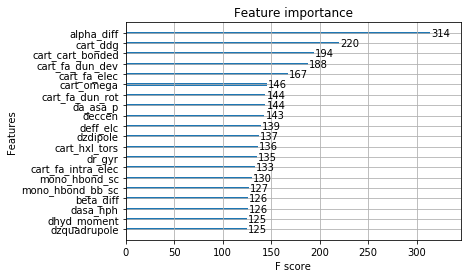

In [0]:
# Plot basic feature importance
xgb.plot_importance(model, max_num_features=20)
pyplot.show()

In [0]:
with open(model_folder_loc+"model_paper_xgboost_T1626.pkl", 'wb') as handle:
    pkl.dump(model, handle, protocol=pkl.HIGHEST_PROTOCOL)

### Model paper (filtered) (S_E_f)

In [0]:
# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_paper.loc[unambiguous_mut_filter], y_label[unambiguous_mut_filter])

In [0]:
# Compute best parameters (average)
params = parameter_table_paper.sort_values("scores_mae")[["colsample_bytree", "eta", "gamma",	"max_depth", "subsample"]].iloc[0].to_dict()
params['max_depth'] = int(params['max_depth'])
params['eval_metric'] = "mae"
params['objective'] = 'reg:linear'
params['tree_method'] = 'exact'

In [0]:
# Train a new model with the best parameters from the search
model = xgb.train(params, dtrain, num_boost_round=1000)

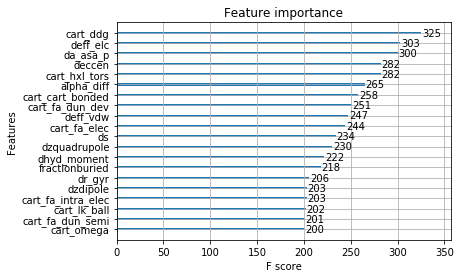

In [0]:
# Plot basic feature importance
xgb.plot_importance(model, max_num_features=20)
pyplot.show()

In [0]:
with open(model_folder_loc+"model_paper_xgboost_T1626_filtered.pkl", 'wb') as handle:
    pkl.dump(model, handle, protocol=pkl.HIGHEST_PROTOCOL)

### Model seq_rep (A13)

In [0]:
# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_seq_all_01_02_03, y_label)

In [0]:
# Compute best parameters (average)
params = parameter_table_seq_rep.sort_values("scores_mae")[["colsample_bytree", "eta", "gamma",	"max_depth", "subsample"]].iloc[0].to_dict()
params['max_depth'] = int(params['max_depth'])
params['eval_metric'] = "mae"
params['objective'] = 'reg:linear'
params['tree_method'] = 'exact'

In [0]:
# Train a new model with the best parameters from the search
model = xgb.train(params, dtrain, num_boost_round=1000)

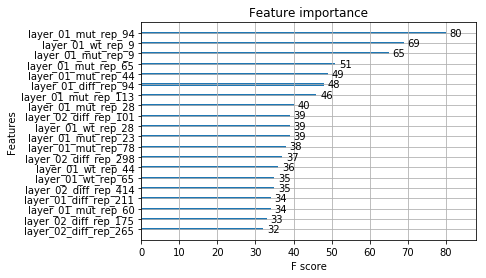

In [0]:
# Plot basic feature importance
xgb.plot_importance(model, max_num_features=20)
pyplot.show()

In [0]:
with open(model_folder_loc+"model_cnn_all_01_02_03_xgboost_T1626.pkl", 'wb') as handle:
    pkl.dump(model, handle, protocol=pkl.HIGHEST_PROTOCOL)

### Model seq_rep (filtered) (A13_f)

In [0]:
# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_seq_all_01_02_03.loc[unambiguous_mut_filter], y_label[unambiguous_mut_filter])

In [0]:
# Compute best parameters (average)
params = parameter_table_seq_rep.sort_values("scores_mae")[["colsample_bytree", "eta", "gamma",	"max_depth", "subsample"]].iloc[0].to_dict()
params['max_depth'] = int(params['max_depth'])
params['eval_metric'] = "mae"
params['objective'] = 'reg:linear'
params['tree_method'] = 'exact'

In [0]:
# Train a new model with the best parameters from the search
model = xgb.train(params, dtrain, num_boost_round=1000)

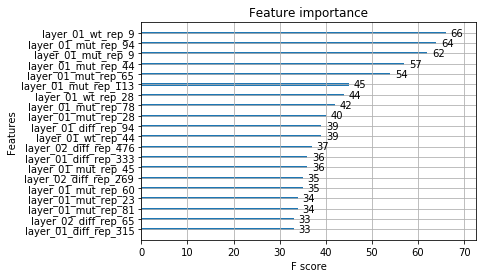

In [0]:
# Plot basic feature importance
xgb.plot_importance(model, max_num_features=20)
pyplot.show()

In [0]:
with open(model_folder_loc+"model_cnn_all_01_02_03_xgboost_T1626_filtered.pkl", 'wb') as handle:
    pkl.dump(model, handle, protocol=pkl.HIGHEST_PROTOCOL)

### Model paper cnn 01 02 03 all (S_E_A13)

In [0]:
# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_paper_all_01_02_03, y_label)

In [0]:
# Compute best parameters (average)
params = parameter_table_combined.sort_values("scores_mae")[["colsample_bytree", "eta", "gamma",	"max_depth", "subsample"]].iloc[0].to_dict()
params['max_depth'] = int(params['max_depth'])
params['eval_metric'] = "mae"
params['objective'] = 'reg:linear'
params['tree_method'] = 'exact'

In [0]:
# Train a new model with the best parameters from the search
model = xgb.train(params, dtrain, num_boost_round=1000)

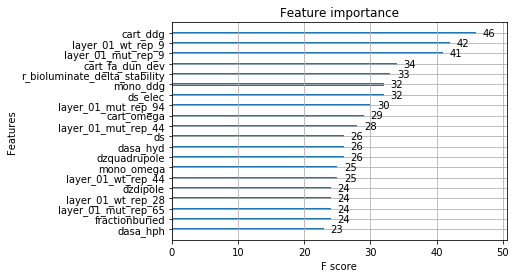

In [0]:
# Plot basic feature importance
xgb.plot_importance(model, max_num_features=20)
pyplot.show()

In [0]:
with open(model_folder_loc+"model_paper_cnn_01_02_03_all_xgboost_T1626.pkl", 'wb') as handle:
    pkl.dump(model, handle, protocol=pkl.HIGHEST_PROTOCOL)

### Model paper cnn 01 02 03 all (filtered) (S_E_A13_f)

In [0]:
# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_paper_all_01_02_03.loc[unambiguous_mut_filter], y_label[unambiguous_mut_filter])

In [0]:
# Compute best parameters (average)
params = parameter_table_combined.sort_values("scores_mae")[["colsample_bytree", "eta", "gamma",	"max_depth", "subsample"]].iloc[0].to_dict()
params['max_depth'] = int(params['max_depth'])
params['eval_metric'] = "mae"
params['objective'] = 'reg:linear'
params['tree_method'] = 'exact'

In [0]:
# Train a new model with the best parameters from the search
model = xgb.train(params, dtrain, num_boost_round=1000)

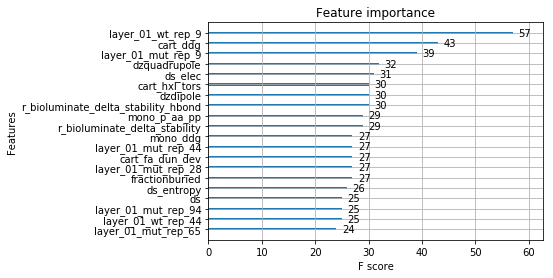

In [0]:
# Plot basic feature importance
xgb.plot_importance(model, max_num_features=20)
pyplot.show()

In [0]:
with open(model_folder_loc+"model_paper_cnn_01_02_03_all_xgboost_T1626_filtered.pkl", 'wb') as handle:
    pkl.dump(model, handle, protocol=pkl.HIGHEST_PROTOCOL)